In [1]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2
from keras.datasets import cifar10
from keras.constraints import maxnorm
from keras.utils import np_utils
from tensorflow.keras.optimizers import SGD


##Data preprocessing

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

assert X_train.shape == (50000, 32, 32, 3)
assert X_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

# normalize inputs from 0-255 to 0.0-1.0
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

##1.1 Base model summary

In [3]:
# Create model
modelb = Sequential()
modelb.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', strides=1, padding='same', kernel_initializer='he_uniform', input_shape=(32, 32, 3)))
modelb.add(MaxPooling2D(pool_size=2, strides=2))
modelb.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', strides=1, padding='same', kernel_initializer='he_uniform'))
modelb.add(MaxPooling2D(pool_size=2, strides=2))
modelb.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', strides=1, padding='same', kernel_initializer='he_uniform'))
modelb.add(MaxPooling2D(pool_size=2, strides=2))
modelb.add(Flatten())
modelb.add(Dense(1000, activation='relu', kernel_initializer='he_uniform'))
modelb.add(Dense(num_classes, activation='softmax'))

modelb.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 32)          25632     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 32)         0

##1.2 Training and evaluation

The difference of loss between training data and validation data shows the existence of overfitting. With the processing of epochs, the training loss is decreasing with some fluctuation, whereas the validationg loss decreases and then increases with some fluctuation.

In terms of accuracy, the difference between top 3 training and validation is bigger than that between top 5 training and validation. The overfitting results in that the accuaracy in training data is always higher than that in validation data.The overall accuracy is 68.01%

In [3]:
# Define
sgd = SGD(learning_rate=0.01, momentum=0.9, decay=0.0001)
def top_3_acc(true_label, pred_label):
    return tf.keras.metrics.top_k_categorical_accuracy(true_label, pred_label, k=3)
def top_5_acc(true_label, pred_label):
    return tf.keras.metrics.top_k_categorical_accuracy(true_label, pred_label, k=5)

Accuracy: 68.01%


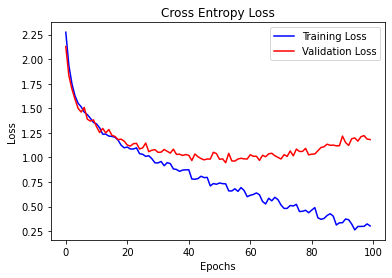

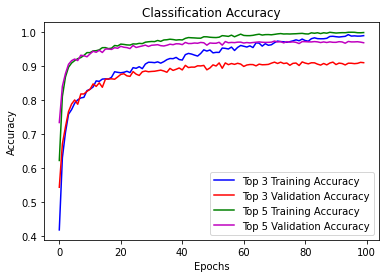

In [5]:
# Compile and fit model
modelb.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy', top_3_acc, top_5_acc])
historyb = modelb.fit(X_train, y_train, validation_split=0.25, epochs=100, batch_size=128, shuffle=True, steps_per_epoch=50, verbose=0)

# Evaluation of the model
scoresb = modelb.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scoresb[1]*100))

# Plot
plt.title('Cross Entropy Loss')
plt.plot(historyb.history['loss'], color='b', label="Training Loss")
plt.plot(historyb.history['val_loss'], color='r', label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.title('Classification Accuracy')
plt.plot(historyb.history['top_3_acc'], color='b', label="Top 3 Training Accuracy")
plt.plot(historyb.history['val_top_3_acc'], color='r',label="Top 3 Validation Accuracy")
plt.plot(historyb.history['top_5_acc'], color='g', label="Top 5 Training Accuracy")
plt.plot(historyb.history['val_top_5_acc'], color='m',label="Top 5 Validation Accuracy")
plt.legend(loc="lower right")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

##1.3 Add a dropout layer

The result shows that, the validation loss doesn't go down as the training loss, but maintain at a certain level at the end of the epochs, which is quiet difference from the last model.

The gap between training and validation accuracy in both top 3 and 5 level shrinks a little bit.  

Compared with the last model, this one with the dropout layer reduces the overfitting apparently. However, there is still some space for further optimization. 

Accuracy: 69.93%


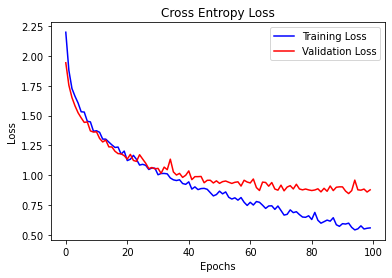

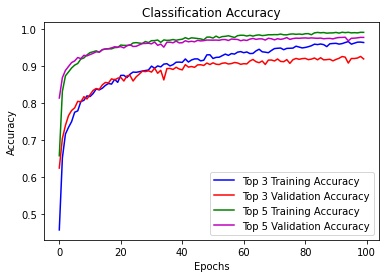

In [17]:
# Create model
modeld = Sequential()
modeld.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', strides=1, padding='same', kernel_initializer='he_uniform', input_shape=(32, 32, 3)))
modeld.add(MaxPooling2D(pool_size=2, strides=2))
modeld.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', strides=1, padding='same', kernel_initializer='he_uniform'))
modeld.add(MaxPooling2D(pool_size=2, strides=2))
modeld.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', strides=1, padding='same', kernel_initializer='he_uniform'))
modeld.add(MaxPooling2D(pool_size=2, strides=2))
modeld.add(Flatten())
modeld.add(Dense(1000, activation='relu', kernel_initializer='he_uniform'))
modeld.add(Dropout(0.25))
modeld.add(Dense(num_classes, activation='softmax'))

# Compile and fit model
modeld.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy', top_3_acc, top_5_acc])
historyd = modeld.fit(X_train, y_train, validation_split=0.25, epochs=100, batch_size=128, shuffle=True, steps_per_epoch=50, verbose=0)

# Evaluation of the model
scoresd = modeld.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scoresd[1]*100))

# Plot
plt.title('Cross Entropy Loss')
plt.plot(historyd.history['loss'], color='b', label="Training Loss")
plt.plot(historyd.history['val_loss'], color='r', label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.title('Classification Accuracy')
plt.plot(historyd.history['top_3_acc'], color='b', label="Top 3 Training Accuracy")
plt.plot(historyd.history['val_top_3_acc'], color='r',label="Top 3 Validation Accuracy")
plt.plot(historyd.history['top_5_acc'], color='g', label="Top 5 Training Accuracy")
plt.plot(historyd.history['val_top_5_acc'], color='m',label="Top 5 Validation Accuracy")
plt.legend(loc="lower right")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

##1.4 different neural network architectures

###model 1: VGG

We first try VGG. This model use 3 VGG blocks and add a dropout layer after each block.

The result is nearly perfect. The training loss and validation loss decrease gradually with epochs and don't vary too much.

The training and validation accuracy increases with the epochs and don't vary too much. Top 5 accuracy is always higher than the top 3 accuracy.  

Accuracy: 75.51%


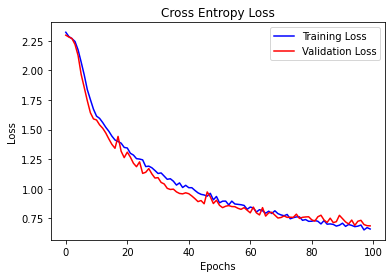

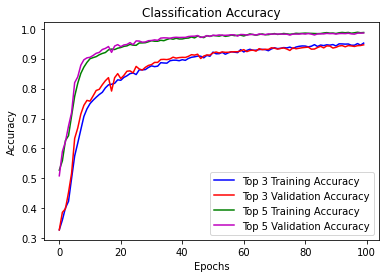

In [5]:
# Create model
model1 = Sequential()
model1.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', strides=1, padding='same', kernel_initializer='he_uniform', input_shape=(32, 32, 3)))
model1.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', strides=1, padding='same', kernel_initializer='he_uniform'))
model1.add(MaxPooling2D())
model1.add(Dropout(0.2))
model1.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', strides=1, padding='same', kernel_initializer='he_uniform'))
model1.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', strides=1, padding='same', kernel_initializer='he_uniform'))
model1.add(MaxPooling2D())
model1.add(Dropout(0.2))
model1.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', strides=1, padding='same', kernel_initializer='he_uniform'))
model1.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', strides=1, padding='same', kernel_initializer='he_uniform'))
model1.add(MaxPooling2D())
model1.add(Dropout(0.2))
model1.add(Flatten())
model1.add(Dense(4096, activation='relu', kernel_initializer='he_uniform'))
model1.add(Dropout(0.2))
model1.add(Dense(1000, activation='relu', kernel_initializer='he_uniform'))
model1.add(Dropout(0.2))
model1.add(Dense(num_classes, activation='softmax'))

# Compile and fit model
model1.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy', top_3_acc, top_5_acc])
history1 = model1.fit(X_train, y_train, validation_split=0.25, epochs=100, batch_size=256, shuffle=True, steps_per_epoch=50, verbose=0)

# Evaluation of the model
scores1 = model1.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores1[1]*100))

# Plot
plt.title('Cross Entropy Loss')
plt.plot(history1.history['loss'], color='b', label="Training Loss")
plt.plot(history1.history['val_loss'], color='r', label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.title('Classification Accuracy')
plt.plot(history1.history['top_3_acc'], color='b', label="Top 3 Training Accuracy")
plt.plot(history1.history['val_top_3_acc'], color='r',label="Top 3 Validation Accuracy")
plt.plot(history1.history['top_5_acc'], color='g', label="Top 5 Training Accuracy")
plt.plot(history1.history['val_top_5_acc'], color='m',label="Top 5 Validation Accuracy")
plt.legend(loc="lower right")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

###model 2: VGG with batch normalization


In this model, we try to find out how the batch normalization and increasing dropout proportion can contribute to the model compared with the previous ordinary VGG model. 

The cross entropy loss decrease significantly at the biginning, and maintain at almost the same level for the remain epochs.

Although there is some oscillation in the validation set, the classification accuracy is 76.32%, which is higher than 73.15% of the ordinary VGG block without batch normalization and increasing dropout proportion.

Accuracy: 76.32%


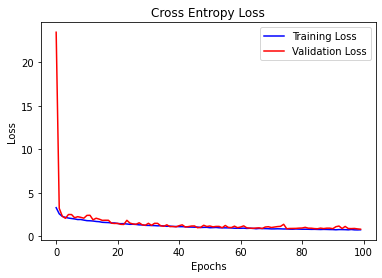

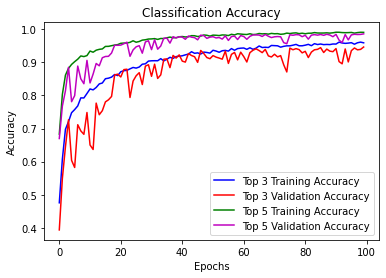

In [4]:
# Create model
model2 = Sequential()

model2.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', strides=1, padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001), input_shape=(32, 32, 3)))
model2.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', strides=1, padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
model2.add(BatchNormalization())
model2.add(MaxPooling2D())
model2.add(Dropout(0.2))

model2.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', strides=1, padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
model2.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', strides=1, padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
model2.add(BatchNormalization())
model2.add(MaxPooling2D())
model2.add(Dropout(0.3))

model2.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', strides=1, padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
model2.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', strides=1, padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
model2.add(BatchNormalization())
model2.add(MaxPooling2D())
model2.add(Dropout(0.4))
model2.add(Flatten())

model2.add(Dense(4096, activation='relu', kernel_initializer='he_uniform'))
model2.add(BatchNormalization())
model2.add(Dense(1000, activation='relu', kernel_initializer='he_uniform'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(num_classes, activation='softmax'))

# Compile and fit model
model2.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy', top_3_acc, top_5_acc])
history2 = model2.fit(X_train, y_train, validation_split=0.25, epochs=100, batch_size=256, shuffle=True, steps_per_epoch=50, verbose=0)

# Evaluation of the model
scores2 = model2.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores2[1]*100))

# Plot
plt.title('Cross Entropy Loss')
plt.plot(history2.history['loss'], color='b', label="Training Loss")
plt.plot(history2.history['val_loss'], color='r', label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.title('Classification Accuracy')
plt.plot(history2.history['top_3_acc'], color='b', label="Top 3 Training Accuracy")
plt.plot(history2.history['val_top_3_acc'], color='r',label="Top 3 Validation Accuracy")
plt.plot(history2.history['top_5_acc'], color='g', label="Top 5 Training Accuracy")
plt.plot(history2.history['val_top_5_acc'], color='m',label="Top 5 Validation Accuracy")
plt.legend(loc="lower right")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()